In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger

os.environ["KERAS_BACKEND"] = "torch"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import keras
keras.utils.set_random_seed(812)

2024-06-10 19:56:04.056994: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 19:56:04.081428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 19:56:04.531062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mmgsilva (mmgsilvawb). Use `wandb login --relogin` to force relogin


True

In [3]:
run = wandb.init(
    dir = "../results/syntheticdata/",
    project = "indexes_subsequence_lstm"
)

In [6]:

data_scenario2 = data.copy()
interval = 20
print("Interval window", interval)
motif_indexes_scenario2 = []
for i in range(0, n, interval):
    motif_indexes_scenario2.append(np.random.randint(i, i + interval - p))

print("Planted motifs:", len(motif_indexes_scenario2))
print(motif_indexes_scenario2)
for i in motif_indexes_scenario2:
    for j in range(k):
        data_scenario2[j, i:i+p] = motif_pattern
#save to file as csv
data_scenario2 = data_scenario2.astype(int)
np.savetxt("../data/syntheticdata/scenario2.csv", data_scenario2, delimiter=",")
np.savetxt("../data/syntheticdata/motif_indexes_scenario2.csv", motif_indexes_scenario2, delimiter=",")

Interval window 20
Planted motifs: 5000
[14, 24, 43, 73, 92, 113, 121, 153, 166, 192, 206, 225, 242, 269, 286, 310, 324, 350, 361, 385, 406, 433, 449, 466, 487, 509, 522, 542, 567, 581, 610, 623, 651, 666, 683, 708, 725, 748, 766, 782, 803, 826, 852, 866, 884, 909, 934, 952, 964, 993, 1012, 1024, 1043, 1061, 1086, 1106, 1122, 1151, 1174, 1188, 1212, 1227, 1248, 1264, 1280, 1311, 1325, 1351, 1370, 1383, 1405, 1432, 1446, 1472, 1489, 1508, 1520, 1541, 1562, 1590, 1612, 1626, 1646, 1673, 1688, 1709, 1727, 1744, 1771, 1791, 1805, 1830, 1846, 1869, 1886, 1908, 1923, 1940, 1969, 1994, 2006, 2031, 2049, 2072, 2081, 2109, 2133, 2141, 2165, 2183, 2214, 2224, 2249, 2262, 2281, 2312, 2329, 2354, 2373, 2389, 2408, 2426, 2443, 2461, 2480, 2506, 2524, 2554, 2561, 2582, 2606, 2633, 2653, 2661, 2682, 2705, 2734, 2753, 2763, 2785, 2813, 2832, 2852, 2870, 2883, 2900, 2929, 2948, 2963, 2986, 3012, 3021, 3049, 3060, 3090, 3105, 3130, 3145, 3169, 3191, 3213, 3224, 3243, 3273, 3283, 3300, 3328, 3342, 3366, 

In [ ]:
#create synthetic multivariate time series random uniform integers
n = 100000
k = 1
data = np.random.randint(1, 6, (k, n)) #k timeseries of length n

data_scenario2 = data.copy()

#select random timewindows of length 5 without overlapping
motif_indexes_scenario2 = []
motif_pattern = [1,1,1,1,1]
p = len(motif_pattern)

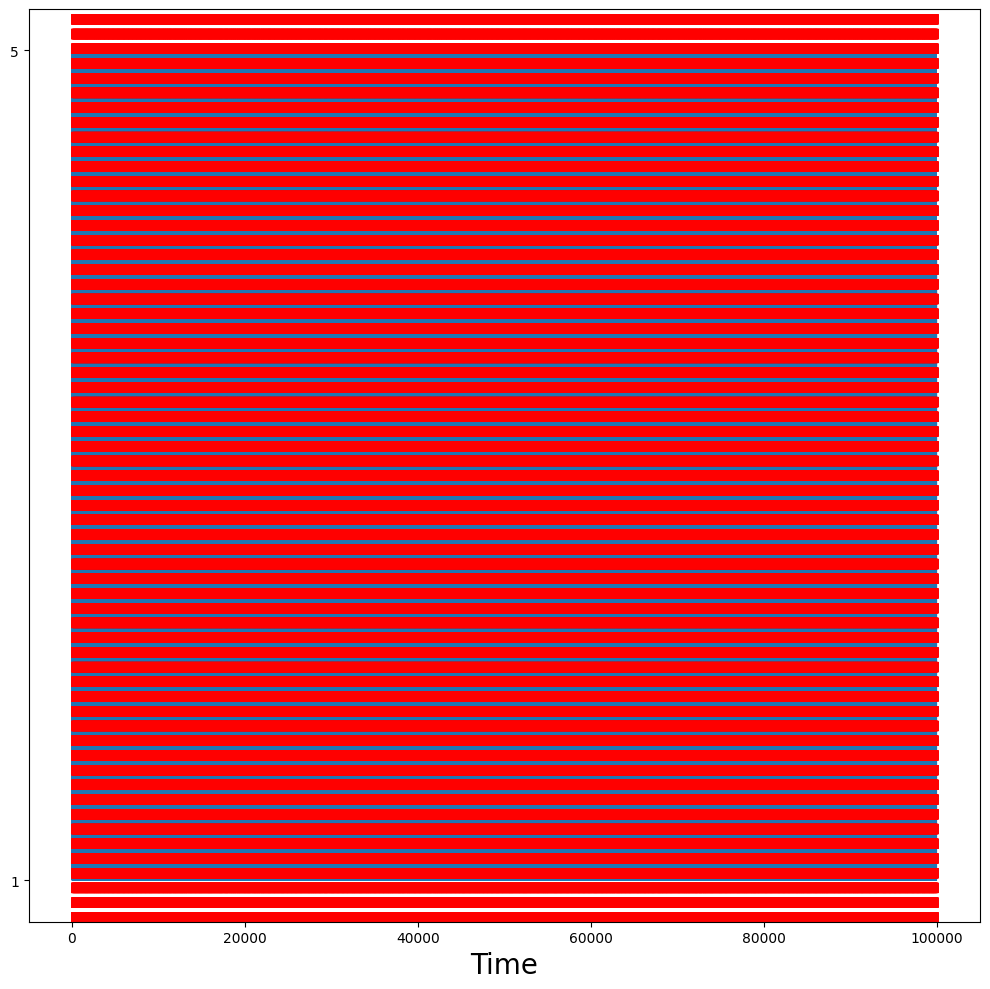

In [7]:
variable_indexes = np.arange(k)
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes_scenario2:
    data_scenario2[variable_indexes,idx:idx+p] = motif_pattern

#introduce clue in the data
for idx in motif_indexes_scenario2:
    data_scenario2[variable_indexes,idx-10:idx-10+3] = [1,2,3]

data_scenario2 = data_scenario2.astype(int)
np.savetxt("../data/syntheticdata/scenario2_withhint.csv", data_scenario2, delimiter=",")


#plot multivariate data using subplots in red the planted motifs
fig, axis = plt.subplots(nrows=k, ncols=1, figsize=(10, 10), sharex=True)
for i, variable in enumerate(variable_indexes):
 plt.subplot(len(variable_indexes), 1, i+1)
 #y axis from 1 to 5
 plt.yticks([1,5])
 plt.plot(data_scenario2[variable], linewidth=0.5)
 #plot the planted motifs
 for idx in motif_indexes_scenario2:
    plt.axvline(x=idx, color='r', linestyle='--', linewidth=2)
plt.xlabel('Time', size=20)
plt.tight_layout()
plt.savefig("../images/data_scenario2_withhint.pdf")
plt.show()

In [8]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data,variable_indexes, past_window, step, forward_window, motif_indexes):
    X1, X2, y = list(), list(),  list() # X1: data, X2: indexes of the motifs, y: distance to the next motif
    for idx in range(len(data[0]) - past_window - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + past_window
        forward_window__end = window_end_idx + forward_window

        #if doesnt exist more matches after the window
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        motif_indexes_in_window = [motif_idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forward_window = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forward_window__end]

        if motif_indexes_in_forward_window:
            next_match_in_forward_window = motif_indexes_in_forward_window[0]
        else:
            next_match_in_forward_window = -1  #no match in forward window but exist in the future

        data_window = data[variable_indexes,idx:window_end_idx]

        data_y = -1 
        if next_match_in_forward_window != -1:
            # index of the next match relative to the last match in the window
            #data_y = next_match_in_forward_window - motif_indexes_in_window[-1] 
            # index of the next match relative to the end of the window
            data_y = next_match_in_forward_window - window_end_idx
        
        X1.append(data_window)
        X2.append(motif_indexes_in_window) #TODO: doesnt seem to make sense to use absolute indexes
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2) , np.array(y)

In [9]:
#load data
data_scenario2 = np.genfromtxt("../data/syntheticdata/scenario2_withhint.csv", delimiter=",")
data_scenario2 = data_scenario2.astype(int)
motif_indexes_scenario2 = np.genfromtxt("../data/syntheticdata/motif_indexes_scenario2.csv", delimiter=",")
motif_indexes_scenario2= motif_indexes_scenario2.astype(int)

indexes_masking = np.zeros(n)
for motif_index in motif_indexes_scenario2:
    indexes_masking[motif_index:motif_index+p] = 1

data_scenario2_masking = data_scenario2.copy()
data_scenario2_masking = np.vstack((data_scenario2_masking, indexes_masking))

past_window = 100 #window size
step = 1 #step size for the sliding window
forward_window = 100 #forward window size
#x1: past window + masking, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2 , y  = create_dataset(data_scenario2_masking,variable_indexes=np.arange(k+1), past_window=past_window, step=step, forward_window=forward_window, motif_indexes=motif_indexes_scenario2)
print(X1.shape, X2.shape, y.shape)
print(X1[0,0], X2[0], y[0])

X1 = np.transpose(X1, (0, 2, 1)) #reshape input to be [samples, time steps, features]
print(X1.shape)

(99846, 2, 100) (99846, 2) (99846,)
[4. 1. 1. 4. 2. 4. 1. 5. 3. 4. 5. 1. 1. 4. 1. 3. 1. 3. 3. 4. 2. 3. 2. 4.
 2. 1. 3. 4. 3. 1. 2. 5. 3. 2. 3. 4. 2. 5. 5. 1. 3. 4. 5. 1. 4. 5. 2. 3.
 1. 4. 4. 4. 5. 5. 1. 1. 4. 2. 4. 3. 2. 1. 2. 5. 4. 5. 5. 3. 4. 3. 4. 2.
 4. 2. 1. 1. 2. 1. 5. 2. 5. 3. 2. 4. 1. 3. 1. 1. 1. 5. 2. 5. 4. 5. 1. 5.
 5. 3. 3. 3.] [-1 -1] -1
(99846, 100, 2)


In [10]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [11]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

import keras_tuner as kt

class MyHyperModel_LSTM(kt.HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        units = hp.Int('units', min_value=10, max_value=100, step=10)
        model.add(LSTM(units=units, activation='tanh', return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model

In [13]:
import collections
from keras.callbacks import EarlyStopping
import pickle
from sklearn.preprocessing import MinMaxScaler



class CVTuner(kt.engine.tuner.Tuner):

    def __init__(self, *args, **kwargs):
        super(CVTuner, self).__init__(*args, **kwargs)
        # cols are metrics-val_loss, val_mae, val_rmse, val_r2
        self.metrics_history = []
        #if exists load metrics history
        if os.path.exists(os.path.join(self.project_dir, "metrics_history.npy")):
            self.metrics_history = np.load(os.path.join(self.project_dir, "metrics_history.npy"), allow_pickle=True)
        

    def run_trial(self, trial, x, y, *args, **kwargs):
        callbacks = kwargs.pop("callbacks", [])
        callbacks.append(EarlyStopping(patience=10, monitor="val_loss"))
        verbose = kwargs.pop("verbose", 0)
        batch_size = trial.hyperparameters.Choice('batch_size', values=[8,16,32,64])

        metrics = collections.defaultdict(list)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        trial_metrics = np.zeros((5, 4), dtype=np.float32)
        for i, (train_indices, test_indices) in enumerate(cv.split(x)):
            #split train indices into train and validation
            mid = int(0.8 * len(train_indices))
            train_indices, val_indices = train_indices[:mid], train_indices[mid:]
            X_train, X_val, X_test = x[train_indices], x[val_indices], x[test_indices]
            y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test) 
            metrics["test_loss"].append(test_loss)
            metrics["test_mae"].append(test_mae)
            metrics["test_rmse"].append(test_rmse)
            metrics["test_r2"].append(test_r2)
            #save metrics
            for j, (_, value) in enumerate(metrics.items()):
                trial_metrics[i, j] = value[-1]

        self.metrics_history.append(trial_metrics)
        print({name: np.mean(values) for name, values in metrics.items()})
        #save cross validation metrics
        return {name: np.mean(values) for name, values in metrics.items()}
    
    def save_metrics(self):
        # aggregate metric_history into a matrix (num trials, num folds, num metrics)
        fname = os.path.join(self.project_dir, "metrics_history.npy")
        np.save(fname, np.array(self.metrics_history))
    
    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)

tuner = CVTuner(
  hypermodel=MyHyperModel_LSTM(input_shape=(X1.shape[1], X1.shape[2])),
  oracle=kt.oracles.GridSearchOracle(
    objective=kt.Objective("test_loss", "min"),
    max_trials=None),
    directory='../results/syntheticdata',
    project_name='series_masking_relativeindex_lstm')
    

X1_normalized = X1.copy()
scalers = []
for i in range(X1.shape[2]-1):
    scaler = MinMaxScaler()
    X1_normalized[:,:,i] = scaler.fit_transform(X1[:,:,i])
    scalers.append(scaler)

tuner.search(
        x=X1_normalized,
        y=y,
        verbose=1,
        callbacks=[WandbMetricsLogger(log_freq=5)],
    )
run.finish()
tuner.save_metrics()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
10                |10                |units
0.01              |0.01              |learning_rate

Epoch 1/400
1553/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 122.2706 - mae: 3.4388 - r2_score: -0.0028 - root_mean_squared_error: 11.0335

KeyboardInterrupt: 

In [13]:
metrics_history = np.array(tuner.metrics_history)
metrics_history.shape

(72, 5, 4)

In [14]:
tuner.results_summary()

Results summary
Results in ../results/syntheticdata/series_masking_relativeindex_lstm
Showing 10 best trials
Objective(name="test_loss", direction="min")

Trial 0000 summary
Hyperparameters:
units: 50
learning_rate: 0.001
batch_size: 8
Score: 985.6118377685547

Trial 0036 summary
Hyperparameters:
units: 80
learning_rate: 0.001
batch_size: 8
Score: 1106.46328125

Trial 0024 summary
Hyperparameters:
units: 70
learning_rate: 0.001
batch_size: 8
Score: 1120.3693359375

Trial 0048 summary
Hyperparameters:
units: 90
learning_rate: 0.001
batch_size: 8
Score: 1125.7013549804688

Trial 0012 summary
Hyperparameters:
units: 60
learning_rate: 0.001
batch_size: 8
Score: 1138.9838989257812

Trial 0060 summary
Hyperparameters:
units: 100
learning_rate: 0.001
batch_size: 8
Score: 1164.1197387695313

Trial 0037 summary
Hyperparameters:
units: 80
learning_rate: 0.001
batch_size: 16
Score: 1176.0567749023437

Trial 0025 summary
Hyperparameters:
units: 70
learning_rate: 0.001
batch_size: 16
Score: 1177.85

In [15]:
import keras
#get config of the best model
best_trial = tuner.oracle.get_best_trials(1)[0]

print(best_trial.hyperparameters.values)
print(best_trial.metrics.get_best_value("test_mae"))

#load metrics history
metrics_history = np.load(tuner.project_dir + "/metrics_history.npy", allow_pickle=True)
print(metrics_history[int(tuner.oracle.get_best_trials(1)[0].trial_id)])

#train the best model, using the best hyperparameters
cv = BlockingTimeSeriesSplit(5)
metrics = []

for i, (train_indices, test_indices) in enumerate(cv.split(X1)):
    mid = int(0.8 * len(train_indices))
    train_indices, val_indices = train_indices[:mid], train_indices[mid:]
    X_train, X_val, X_test = X1[train_indices], X1[val_indices], X1[test_indices]
    y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
    model = MyHyperModel_LSTM(input_shape=(X1.shape[1],X1.shape[2])).build((best_trial.hyperparameters))
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=best_trial.hyperparameters.get("batch_size"), verbose=0, callbacks=EarlyStopping(patience=10, monitor="val_loss"))
    test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test)
    metrics.append([test_loss, test_mae, test_rmse, test_r2])

keras.utils.plot_model(model, to_file="../images/best_model_lstm.png", show_shapes=True)
metrics = np.array(metrics)
metrics.mean(axis=0)

{'units': 50, 'learning_rate': 0.001, 'batch_size': 16}
25.294038772583008
[[ 133.18906    11.502771   11.540756 -151.15613 ]
 [1138.4069     33.502056   33.740284  -70.15043 ]
 [ 494.94656    21.964005   22.247395  -38.45936 ]
 [ 908.46344    30.14073    30.140728    0.      ]
 [ 862.0466     29.360632   29.36063     0.      ]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 133.7332 - mae: 11.5272 - r2_score: -156.0213 - root_mean_squared_error: 11.5642 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.7689 - mae: 4.5580 - r2_score: -1.3012 - root_mean_squared_error: 6.0631 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.6910 - mae: 1.3649 - r2_score: -0.1283 - root_mean_squared_error: 3.5441
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.6992 - mae: 5.1671 - r2_score: 0.0000e+00 - root_mean_squared_error: 5.1671 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.0196 - mae: 4.6925 - r2_score: 0.0000e+00 - root_mean_squared_error: 4.6925 


array([ 46.45619354,   5.4744859 ,   6.23958783, -30.49242473])

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


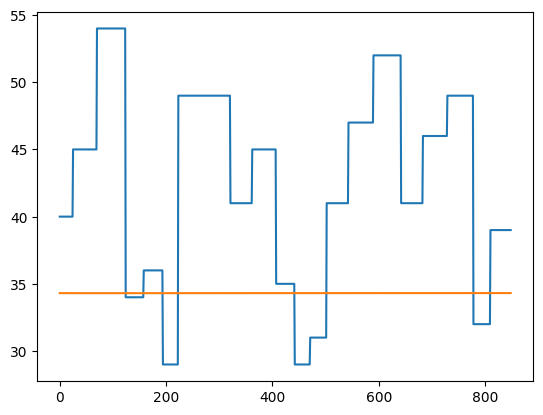

In [16]:
#plot prediction vs true values
y_pred = model.predict(X1)

plt.plot(y, label="True")
plt.plot(y_pred, label="Predicted")


In [ ]:
from keras.layers import Concatenate
class MyHyperModel_FFNN(kt.HyperModel):
    def __init__(self, time_series_shape, pattern_shape):
        self.time_series_shape = time_series_shape
        self.pattern_shape = pattern_shape

    def build(self, hp):
        series_input = keras.Input(shape=self.time_series_shape, name="time-series")  
        motif_indexes_input = keras.Input(shape=(None,), name="motif_indexes")  # Variable-length 
        pattern_input = keras.Input(shape=self.pattern_shape, name="pattern")  

        x = Concatenate([series_input, motif_indexes_input, pattern_input])

        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model

In [ ]:
tuner = CVTuner(
  hypermodel=MyHyperModel_FFNN(time_series_shape=(X1.shape[1], X1.shape[2]), pattern_shape=(X2.shape[1], X2.shape[2])),
  oracle=kt.oracles.GridSearchOracle(
    objective=kt.Objective("test_loss", "min"),
    max_trials=None),
    directory='../results/syntheticdata',
    project_name='series_pattern_indexes_relativeindex_ffnn')

x = {"time-series": X1, "motif_indexes": X2, "pattern": }
tuner.search(
        x=x,
        y=y,
        verbose=1,
        callbacks=[WandbMetricsLogger(log_freq=5)],
    )
run.finish()
tuner.save_metrics()